# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [16]:
def P1(num_examples=5):
### STUDENT START ###
    for ix, i in enumerate(train_data[:5]):
        print '#Label: ' + str(newsgroups_train.target_names[train_labels[ix]]) + '\n' + '#Message: ' + str(i) + '\n'
### STUDENT END ###
P1()

#Label: comp.graphics
#Message: Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

#Label: talk.religion.misc
#Message: 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for ce

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [79]:
def P2():
### STUDENT START ###
    # a. Standard vocabulary
    vectorizer = CountVectorizer()
    featureVectors = vectorizer.fit_transform(train_data)
    
    vocabSize = featureVectors.shape[1]
    entries = featureVectors.shape[0]
    nonZeroCount = featureVectors.nnz / float(entries)
    nonZeroFraction = (featureVectors.nnz / float(entries*vocabSize))

    print "Size of vacabulary: " + str(vocabSize)
    print "Number of non-zero features per example: " + str(nonZeroCount)
    print "Fraction of non-zero entries: " + str(nonZeroFraction)
    
    # b. Print feature strings
    featureNames = vectorizer.get_feature_names()
    print "\nFirst feature: " + featureNames[0]
    lastFeature = len(featureNames) - 1
    print "Last feature: " + featureNames[lastFeature]
    
    # c. Build custom vocabulary and caclulate average non-zero features per example
    customVectorizer = CountVectorizer()
    customVectorizer.fit(["atheism", "graphics", "space", "religion"])
    customVectors = customVectorizer.transform(train_data)
    customNonZeroCount = customVectors.nnz / float(customVectors.shape[0])
    print "\nSize of custom vocabulary: " + str(customVectors.shape[1])
    print "Number of non-zero features per example: " + str(customNonZeroCount)
    
    # d. Bigram and trigrams
    bigramVectorizer = CountVectorizer(analyzer='char_wb',ngram_range=(2,2))
    bigramFeatures = bigramVectorizer.fit_transform(train_data)
    print "\nSize of bigram vocabulary: " + str(bigramFeatures.shape[1])
    trigramVectorizer = CountVectorizer(analyzer='char_wb',ngram_range=(3,3))
    trigramFeatures = trigramVectorizer.fit_transform(train_data)
    print "Size of trigram vocabulary: " + str(trigramFeatures.shape[1])
    
    # e. Minimum document frequency
    documentFreq = (float(10)/entries)
    dfVectorizer = CountVectorizer(min_df=documentFreq)
    dfFeatures = dfVectorizer.fit_transform(train_data)
    print "\nSize of vocabulary with minimum document frequency of 10: " + str(dfFeatures.shape[1])
    
    # f. Fraction of words missing in dev data
    devVectorizer = CountVectorizer()
    devFeatures = devVectorizer.fit_transform(dev_data)
    devFeatureNames = devVectorizer.get_feature_names()
    devUnique = list(set(devFeatureNames)-set(featureNames))
    print "\nFraction of words in Dev data missing from training vocabulary: " + str(float(len(devUnique)) / vocabSize)
### STUDENT END ###
P2()

Size of vacabulary: 26879
Number of non-zero features per example: 96.7059980334
Fraction of non-zero entries: 0.00359782722696

First feature: 00
Last feature: zyxel

Size of custom vocabulary: 4
Number of non-zero features per example: 0.268436578171

Size of bigram vocabulary: 3090
Size of trigram vocabulary: 25864

Size of vocabulary with minimum document frequency of 10: 3064

Fraction of words in Dev data missing from training vocabulary: 0.14981956174


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [33]:
def P3():
### STUDENT START ###
    # KNN
    vectorizer = CountVectorizer()
    featureVectors = vectorizer.fit_transform(train_data)
    devVectors = vectorizer.transform(dev_data)
    
    kValues = list(range(1,120))
    knnC = KNeighborsClassifier()
    knnCV = GridSearchCV(knnC, {'n_neighbors': kValues}, cv=10)
    knnCV.fit(featureVectors,train_labels)
    
    knn = KNeighborsClassifier(n_neighbors=115)
    knn.fit(featureVectors,train_labels)
    knnPred = knn.predict(devVectors)
    f1 = metrics.f1_score(dev_labels, knnPred, average='weighted')
    
    print "The optimal value for k is: " + str(knnCV.best_params_) + " with an f1 value of: " + str(f1)
        
    # Multinomial Naive Bayes
    alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    nb = MultinomialNB()
    gcv = GridSearchCV(nb, alphas)
    gcv.fit(featureVectors,train_labels)
    
    mnb = MultinomialNB(alpha=0.01)
    mnb.fit(featureVectors,train_labels)
    mnbPred = mnb.predict(devVectors)
    mnbF1 = metrics.f1_score(dev_labels, mnbPred, average='weighted')
    print "The optimal alpha value for MultinomialNB is: " + str(gcv.best_params_) + " with an f1 value of: " + str(mnbF1)
    
    # Logistic Regression
    cValues = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    cParam = {'C': cValues }
    lrcv = GridSearchCV(LogisticRegression(penalty='l2'), cParam)
    lrcv.fit(featureVectors,train_labels)
    
    lr = LogisticRegression(C=.1)
    lr.fit(featureVectors,train_labels)
    lrPred = lr.predict(devVectors)
    lrF1 = metrics.f1_score(dev_labels, lrPred, average='weighted')
    
    print "The optimal value for C is: " + str(lrcv.best_params_) + " with an f1 value of: " + str(lrF1) + "\n"
                                                                                                   
    for i in cValues:
        lr1 = LogisticRegression(C=i)
        lr1.fit(featureVectors,train_labels)                                                                                        
        print "Sum of squared weight values for C = " + str(i) + ": " + str(np.sum(lr1.coef_**2,axis=1))
    
### STUDENT END ###
P3()

The optimal value for k is: {'n_neighbors': 115} with an f1 value of: 0.456367820506
The optimal alpha value for MultinomialNB is: {'alpha': 0.01} with an f1 value of: 0.775166321854
The optimal value for C is: {'C': 0.1} with an f1 value of: 0.696624354242

Sum of squared weight values for C = 0.001: [ 0.16509345  0.20095275  0.18067094  0.18724278]
Sum of squared weight values for C = 0.01: [ 2.54146954  2.93970937  2.86246896  2.2500287 ]
Sum of squared weight values for C = 0.1: [ 27.13317322  24.65147536  27.45876821  23.02521796]
Sum of squared weight values for C = 1: [ 166.99331679  130.9193461   157.98832939  145.73762693]
Sum of squared weight values for C = 10: [ 586.30941226  448.23936457  539.52607615  530.60143665]
Sum of squared weight values for C = 100: [ 1261.5178471   1085.65788198  1303.79929034  1319.41464331]
Sum of squared weight values for C = 1000: [ 2657.9120445   1914.69649488  2450.37375553  1836.59659761]


ANSWER:
a. The issue with K nearest neighbors: We are working with a very sparse and wide feature set. This means the curse of dimensionality is very real and something that must be considered when choosing a model. The Knn model is directly dependent on the feature(s) nearest (does not make any assumptions whatsoever). So modeling a sparse feature set with the knn model will likely have difficulty matching non-zero features.

b. The number of training examples we are working with is only slightly more than 2000. Using a smaller amount of training examples such as this, Logistic Regression is more likely to overfit the training set. Naive Bayes does better because it models the whole joint distribution, helping to avoid overfitting on a smaller training set.

c. For each value of C, each increasing by a factor of 10, we find that the sum of squared weight values increases by at least two times. The increase being most dramatic increasing from the smallest C values.  

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [76]:
def weightsTable(lr, featureNames):
    table = []
    for ix, i in enumerate(lr.coef_): # iterate over each class
        classWeights = []
        ind = np.argpartition(lr.coef_[ix], -5)[-5:] # find top 5 weights for class
        a = [0,1,2,3]
        a.remove(ix)
        a = [ix] + a
        for clsI in a: # find weights for each class
            for feaIx, feaI in enumerate(ind): # iterate over each top weight
                className = newsgroups_train.target_names[clsI]
                feaName = featureNames[feaI]
                weight = lr.coef_[clsI][feaI]
                formattedWeights = str(className)+":"+str(feaName)+"="+str("%.2f" % round(weight,2)) 
                classWeights = classWeights + [formattedWeights]
        table.append(classWeights)
        
    l1 = table[0]
    l2 = table[1]
    l3 = table[2]
    l4 = table[3]
    for row in zip(l1, l2, l3, l4):
        print ' | '.join(row)

def P4():
### STUDENT START ###
    # Logistic Regression
    vectorizer = CountVectorizer()
    featureVectors = vectorizer.fit_transform(train_data)
    lr = LogisticRegression(C=.1)
    lr.fit(featureVectors,train_labels)
    featureNames = vectorizer.get_feature_names()
    featureNames = np.array(featureNames)
    
    weightsTable(lr,featureNames)
    
    # Logistic Regression on Bigram features
    bigramVectorizer = CountVectorizer(analyzer='char_wb',ngram_range=(2,2))
    bigramFeatureVectors = bigramVectorizer.fit_transform(train_data)
    lrBi = LogisticRegression(C=.1)
    lrBi.fit(bigramFeatureVectors,train_labels)
    biFeatureNames = bigramVectorizer.get_feature_names()
        biFeatureNames = np.array(biFeatureNames)
    
    print "\n Bigram Features: \n" 
    weightsTable(lrBi, biFeatureNames)

### STUDENT END ###
P4()

alt.atheism:islam=0.43 | comp.graphics:3d=0.55 | sci.space:moon=0.40 | talk.religion.misc:fbi=0.42
alt.atheism:atheists=0.46 | comp.graphics:computer=0.56 | sci.space:launch=0.48 | talk.religion.misc:order=0.43
alt.atheism:bobby=0.48 | comp.graphics:file=0.64 | sci.space:nasa=0.54 | talk.religion.misc:christians=0.50
alt.atheism:religion=0.49 | comp.graphics:image=0.64 | sci.space:orbit=0.60 | talk.religion.misc:christian=0.55
alt.atheism:atheism=0.50 | comp.graphics:graphics=1.01 | sci.space:space=1.26 | talk.religion.misc:blood=0.43
comp.graphics:islam=-0.08 | alt.atheism:3d=-0.18 | alt.atheism:moon=-0.20 | alt.atheism:fbi=-0.13
comp.graphics:atheists=-0.08 | alt.atheism:computer=-0.04 | alt.atheism:launch=-0.21 | alt.atheism:order=-0.35
comp.graphics:bobby=-0.12 | alt.atheism:file=-0.18 | alt.atheism:nasa=-0.27 | alt.atheism:christians=-0.33
comp.graphics:religion=-0.30 | alt.atheism:image=-0.26 | alt.atheism:orbit=-0.22 | alt.atheism:christian=-0.26
comp.graphics:atheism=-0.21 | al

ANSWER: One feature that I'm not at all surprised with is the "3d" bigram feature that was identified as the feature with the largest weight for the comp.graphics class. Although not surprising, I find that this feature is a great example of how effective the weights can be in identifying important features for each class. However, the bigram features in general do not seem to be performing as well as the word features after comparing the two tables. This is particularly evident in the final class of the table, talk.religion.misc, where the "hy" top weighted feature is almost weighted as strong in the sci.space class. 

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [124]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    s2 = list(s)
    for ix, text in enumerate(s2):
        processedText = re.sub(r"[^0-9a-zA-Z\s]", "", text).lower()
        processedText = re.sub("[0-9+]", "2", processedText) #this seems to have negatively affected the model
        processedText = " ".join(re.findall(r"\b\w{1,4}", processedText))
        s2[ix] = processedText
    return s2

### STUDENT END ###

def P5():
### STUDENT START ###
    # Get baseline f1 for comparing performance of preprocessor
    print "#Before preprocessing example: " + str(train_data[0])
    baselineTrainData = empty_preprocessor(train_data)
    vectorizer = CountVectorizer()
    featureVectors = vectorizer.fit_transform(baselineTrainData)
    devFeatureVectors = vectorizer.transform(dev_data)

    lr = LogisticRegression(C=.1)
    lr.fit(featureVectors,train_labels)
    lrPred = lr.predict(devFeatureVectors)
    lrF1 = metrics.f1_score(dev_labels, lrPred, average='weighted')
    print "\nBaseline F1: " + str(lrF1)
    
    # Preprocessed training data and not preprocessing dev data (for curiosities sake!)
    processedTrainData = better_preprocessor(train_data)
    print "\n#Post preprocessing example: " +  str(processedTrainData[0])
    betterVectorizer = CountVectorizer()
    betterFeatureVectors = betterVectorizer.fit_transform(processedTrainData)
    unprocessedDevData = better_preprocessor(dev_data)
    unprocessedDevVectors = betterVectorizer.transform(dev_data)

    lr2 = LogisticRegression(C=.1)
    lr2.fit(betterFeatureVectors,train_labels)
    lr2Pred = lr2.predict(unprocessedDevVectors)
    lr2F1 = metrics.f1_score(dev_labels, lr2Pred, average='weighted')
    print "\nF1 score with preprocessed training data predicting unprocessed dev data: " + str(lr2F1) + " just for fun..."
    
    # Preprocessed training data and dev data
    processedDevData = better_preprocessor(dev_data)
    processedDevFeatureVectors = betterVectorizer.transform(processedDevData)
    
    lr3 = LogisticRegression(C=.1)
    lr3.fit(betterFeatureVectors,train_labels)
    lr3Pred = lr3.predict(processedDevFeatureVectors)
    lr3F1 = metrics.f1_score(dev_labels, lr3Pred, average='weighted')
    print "F1 score with preprocessed training data predicting processed dev data: " + str(lr3F1)
    
    originalVocabSize = featureVectors.shape[1]
    vocabSize = betterFeatureVectors.shape[1]
    print "Preprocessed model improvement (F1 points): " + str(lr3F1-lrF1)
    print "Vocab size reduction: " + str(float(vocabSize)/originalVocabSize) 
    
### STUDENT END ###
P5()

#Before preprocessing example: Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Baseline F1: 0.696624354242

#Post preprocessing example: hi ive noti that if you only save a mode with all your mapp plan posi care to a 2ds file that when you relo it afte rest 2ds they are give a defa posi and orie but if you save to a prj file thei posi are pres does anyo know why this info is not stor in the 2ds file noth is expl said in the manu abou 

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

Number of learned weights not equal to zero for l1 regularization: 360
Ratio of learned weights not equal to zero for l1 regularization: 0.00334833885189
Number of learned weights not equal to zero for l2 regularization: 107516
Ratio of learned weights not equal to zero for l2 regularization: 1.0

Logistic Regression trained on non zero weighted features F1: 0.662565004713
[6, 35, 364, 1760, 5600]
[0.34003963017041894, 0.46094882618280614, 0.65944740338150265, 0.673905738569476, 0.68735261489249455]


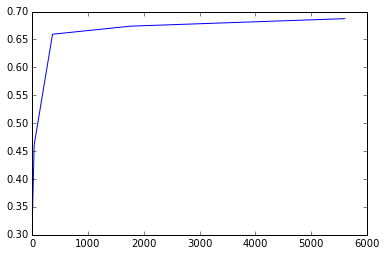

In [5]:
def trimPreprocessor(s):
    s2 = list(s)
    for ix, text in enumerate(s2):
        processedText = re.sub(r"[^0-9a-zA-Z\s]", "", text).lower()
        s2[ix] = processedText
    return s2

'''Function to allow iterations of the pruning with different parameters'''
def prunedModel(c):
    vectorizer = CountVectorizer()
    featureVectors = vectorizer.fit_transform(train_data)
    devFeatureVectors = vectorizer.transform(dev_data)
    
    featureNames = vectorizer.get_feature_names()
    featureNames = np.array(featureNames)
    
    lr = LogisticRegression(C=c, penalty='l1', tol=.01)
    lr.fit(featureVectors,train_labels)
    #lrPred = lr.predict(devFeatureVectors)
    #lrF1 = metrics.f1_score(dev_labels, lrPred, average='weighted')
    
    l1nonZeroFeatures = []
    for i in lr.coef_:
        l1nonZeroFeatures += featureNames[np.nonzero(i)]
        
    betterTrainData = trimPreprocessor(train_data)
    trimTrainData = []
    for ix, i in enumerate(betterTrainData):
        trainDataWords = i.split()
        trimTrainDataWords = [word for word in trainDataWords if word in l1nonZeroFeatures]
        joinTrimWords = ' '.join(trimTrainDataWords)
        trimTrainData.append(joinTrimWords)
    
    # Train l2 logistic regression on features with non zero weights
    nzVectorizer = CountVectorizer()
    nzFeatureVectors = nzVectorizer.fit_transform(trimTrainData)
    nzDevFeatureVectors = nzVectorizer.transform(dev_data)
    
    nzlr = LogisticRegression(C=.1, tol=.01)
    nzlr.fit(nzFeatureVectors,train_labels)
    nzlrPred = nzlr.predict(nzDevFeatureVectors)
    nzlrF1 = metrics.f1_score(dev_labels, nzlrPred, average='weighted')
    
    return (nzlrF1, len(l1nonZeroFeatures))

def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    .transform(X_train_counts)
    
    featureNames = vectorizer.get_feature_names()
    featureNames = np.array(featureNames)
    
    # l1 regularization
    lr = LogisticRegression(C=.1, penalty='l1', tol=.01)
    lr.fit(featureVectors,train_labels)
    lrPred = lr.predict(devFeatureVectors)
    lrF1 = metrics.f1_score(dev_labels, lrPred, average='weighted')
    
    # l2 regularization
    lr2 = LogisticRegression(C=.1, tol=.01)
    lr2.fit(featureVectors,train_labels)
    lr2Pred = lr2.predict(devFeatureVectors)
    lr2F1 = metrics.f1_score(dev_labels, lr2Pred, average='weighted')
    
    # Compare non zero weights accross distinct regularization techniques
    l1nonZeroWeights = 0
    l1totalWeights = 0
    l1nonZeroFeatures = []
    for i in lr.coef_:
        l1nonZeroWeights += np.count_nonzero(i)
        l1totalWeights += len(i)
        l1nonZeroFeatures += featureNames[np.nonzero(i)]
    
    print "Number of learned weights not equal to zero for l1 regularization: " + str(l1nonZeroWeights)
    print "Ratio of learned weights not equal to zero for l1 regularization: "+str(l1nonZeroWeights/float(l1totalWeights))
    
    l2nonZeroWeights = 0
    l2totalWeights = 0
    for i in lr2.coef_:
        l2nonZeroWeights += np.count_nonzero(i)
        l2totalWeights += len(i)
        
    print "Number of learned weights not equal to zero for l2 regularization: " + str(l2nonZeroWeights)
    print "Ratio of learned weights not equal to zero for l2 regularization: "+str(l2nonZeroWeights/float(l2totalWeights))
    
    # Remove features with zero weights
    betterTrainData = trimPreprocessor(train_data)
    trimTrainData = []
    for ix, i in enumerate(betterTrainData):
        trainDataWords = i.split()
        trimTrainDataWords = [word for word in trainDataWords if word in l1nonZeroFeatures]
        joinTrimWords = ' '.join(trimTrainDataWords)
        trimTrainData.append(joinTrimWords)
    
    # Train l2 logistic regression on features with non zero weights
    nzVectorizer = CountVectorizer()
    nzFeatureVectors = nzVectorizer.fit_transform(trimTrainData)
    nzDevFeatureVectors = nzVectorizer.transform(dev_data)
    
    nzlr = LogisticRegression(C=.1, tol=.01)
    nzlr.fit(nzFeatureVectors,train_labels)
    nzlrPred = nzlr.predict(nzDevFeatureVectors)
    nzlrF1 = metrics.f1_score(dev_labels, nzlrPred, average='weighted')
    print "\nLogistic Regression trained on non zero weighted features F1: " + str(nzlrF1)
    
    # Plot model accuracy vs. vocab size with unused feature pruning adjustments
    x = []
    y = []
    for i in [.001, .01, 0.1, 1, 10]:
        f1, nonZeroCount = prunedModel(i)
        x.append(nonZeroCount)
        y.append(f1)
        
    plt.plot(x,y)
    plt.show()
    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [24]:
def P7():
### STUDENT START ###
    vectorizer = CountVectorizer()
    featureVectors = vectorizer.fit_transform(train_data)
    devFeatureVectors = vectorizer.transform(dev_data)
    
    tfidfTransformer = TfidfTransformer()
    tfidfFeatureVectors = tfidfTransformer.fit_transform(featureVectors)
    tfidfDevFeatureVectors = tfidfTransformer.transform(devFeatureVectors)
    
    # Train a logistic regression model on tfidfVecorizer
    tfidfLr = LogisticRegression(C=100, tol=.01)
    tfidfLr.fit(tfidfFeatureVectors,train_labels)
    tfidfPred = tfidfLr.predict(tfidfDevFeatureVectors)
    tfidfF1 = metrics.f1_score(dev_labels, tfidfPred, average='weighted')
    print "\nLogistic Regression trained on term frequency adjusted features F1: " + str(tfidfF1)
    
    # Find top 3 documents with largest R ratio
    predictedProbabilities = tfidfLr.predict_proba(tfidfDevFeatureVectors)
    
    R = []
    predictedLabel = []
    for ppix, pp in enumerate(predictedProbabilities):
        devLabel = dev_labels[ppix]
        maxProbability = 0
        maxProbabilityIx = 0
        correctProbability = 0
        for mpix, mp in enumerate(pp):
            if mpix == devLabel:
                correctProbability = mp
            if mp > maxProbability:
                maxProbability = mp
                maxProbabilityIx = mpix     
        R.append(maxProbability / correctProbability)
        predictedLabel.append(maxProbabilityIx)
    
    np.array(R)
    maxR = np.argpartition(R, -3)[-3:] # find top 3 R values
    
    for ix, i in enumerate(maxR):
        predicted = newsgroups_train.target_names[predictedLabel[i]]
        correct = newsgroups_train.target_names[dev_labels[i]]
        print "\n"+str(ix+1)+". R value: "+str(R[i])
        print "Correct label: "+str(correct)
        print "Predicted label: "+str(predicted)
        print "\n-Document text: " + str(dev_data[i])

## STUDENT END ###
P7()


Logistic Regression trained on term frequency adjusted features F1: 0.76745757333

1. R value: 326.571775246
Correct label: talk.religion.misc
Predicted label: comp.graphics

-Document text: Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.

2. R value: 384.553094302
Correct label: alt.atheism
Predicted label: talk.religion.misc

-Document text: 
The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...


3. R value: 926.909615589
Correct label: talk.religion.misc
Predicted label: comp.graphics

-Document text: I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating

ANSWER: The "tfidf" in TfidVectorizer stands for term frequency-inverse document frequency. This is a statistic that is intended to reflect how important a word is in a document of a collection. It helps adjust for the fact that some words appear more frequently in general, as opposed to the straight term count that the countVectorizer employs.

The model is unable to appropriately weight documents that are very short. Not only were the weights predicting the wrong label on the short documents (example 1 and 2 above), they were predicting the weights incorectly by a very large margin. The 3rd example mistake the model made was due to the nature of the documents features. Although the document was labeled as religon.misc, the model predicted the comp.graphics and with very good intentions. The document is largely discussing the technical details of how to print out a book.

The 3rd mistake would be difficult to avoid as the documents features were not representative of the rest of the labels corpus. However, the 1st and 2nd mistakes on the small documents could at least be minimized. One technique for doing so would be to adjust the weights features are given against the total number of terms in the document. Also, a larger training set of data would help avoid overfitting, which is exactly what I believe happened in this case. A smaller document may only match a couple features on a smaller training data set such as the one we used.  

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.